# 深度学习期末考核报告

## 基本内容

### 库

In [24]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from PIL import Image
import pandas as pd
from tqdm import tqdm
import datetime
import numpy as np
import matplotlib.pyplot as plt
import random
from torchvision.transforms import v2


### 核心配置

In [ ]:
# --- 核心配置区 ---
MODEL_CONFIG = {
    'model_name': 'ConvNeXt-XL', # <--- 目标模型: ConvNeXt-Large
    'batch_size': 32,      # ConvNeXt-L模型很大，建议从较小的batch_size开始，如16或24
    'learning_rate': 1e-4,
    'num_epochs': 60
}

### 基本信息

In [26]:
# 基本设置
student_id = '22211360121'
subdir = ''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用的设备: {device}, 正在配置模型: {MODEL_CONFIG['model_name']}")

使用的设备: cuda, 正在配置模型: ConvNeXt-L


## 数据处理

### 官方推荐预处理

In [27]:
print(f"\n--- 正在为 {MODEL_CONFIG['model_name']} 准备数据和变换 ---")
# 加载 ConvNeXt-Large 的官方预训练权重
weights = models.ConvNeXt_Large_Weights.DEFAULT # <--- 关键修改
model_official_transforms = weights.transforms()
print(f"{MODEL_CONFIG['model_name']} 官方推荐的预处理流程:")
print(model_official_transforms)


--- 正在为 ConvNeXt-L 准备数据和变换 ---
ConvNeXt-L 官方推荐的预处理流程:
ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### 数据增强

In [28]:
# 定义包含高级数据增强的训练集变换
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(384, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    v2.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=model_official_transforms.mean, std=model_official_transforms.std),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2)),
    v2.MixUp(alpha=0.2),
])
# 验证集和测试集使用官方标准变换
val_test_transform = transforms.Compose([
    transforms.Resize(400),
    transforms.CenterCrop(384),
    transforms.ToTensor(),
    transforms.Normalize(mean=model_official_transforms.mean, std=model_official_transforms.std),
])

## 加载数据

In [29]:
full_train_dataset = torchvision.datasets.ImageFolder(root='new data/train')

train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_subset.dataset.transform = train_transform
val_subset.dataset.transform = val_test_transform

train_loader = DataLoader(train_subset, batch_size=MODEL_CONFIG['batch_size'], shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=MODEL_CONFIG['batch_size'], shuffle=False, num_workers=8, pin_memory=True)
class_names = full_train_dataset.classes

print(f"\n训练集大小: {len(train_subset)}, 验证集大小: {len(val_subset)}")


训练集大小: 3199, 验证集大小: 356


## 模型

### 导入模型

In [30]:
# --- 2.3 模型定义、优化器与调度器 ---
# 加载预训练的 ConvNeXt-Large 模型
model = models.convnext_large(weights=weights) # <--- 关键修改

# 替换分类头以适应我们的任务
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, len(class_names))

# 分阶段解冻
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
# 解冻最后一个 stage
for name, param in model.named_parameters():
    if 'stages.3' in name:
        param.requires_grad = True

model.to(device)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

### 优化器与调度器

In [32]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

optimizer = optim.AdamW(model.parameters(), lr=MODEL_CONFIG['learning_rate'], weight_decay=0.01)

from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=MODEL_CONFIG['num_epochs'], eta_min=1e-6)

# 初始化AMP梯度缩放器
scaler = torch.cuda.amp.GradScaler()

C:\Users\Krinv\AppData\Local\Temp\ipykernel_21584\296125885.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


## 训练

### 基本变量

In [ ]:
# --- 2.4 训练与验证循环 (集成AMP) ---
model_save_path = f"bird_classification_convnext_v2_best.pth" # <--- 修改保存路径
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop_patience = 7
train_loss_history, val_loss_history, val_acc_history = [], [], []


### 启动训练

In [34]:
print(f"\n--- 开始为 {MODEL_CONFIG['model_name']} 进行实际训练 ---")

for epoch in range(MODEL_CONFIG['num_epochs']):
    model.train()
    total_train_loss = 0
    train_bar = tqdm(train_loader, desc=f'训练轮次 {epoch+1}/{MODEL_CONFIG["num_epochs"]}')
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()
        train_bar.set_postfix({'loss': f'{loss.item():.4f}', 'lr': f'{optimizer.param_groups[0]["lr"]:.1e}'})
    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    model.eval()
    total_val_loss, total_val_correct = 0, 0
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f'验证轮次 {epoch+1}/{MODEL_CONFIG["num_epochs"]}')
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == labels).sum().item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = total_val_correct / len(val_loader.dataset)
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_accuracy)
    
    print(f'\n轮次 {epoch+1} | 训练损失: {avg_train_loss:.4f} | 验证损失: {avg_val_loss:.4f} | 验证准确率: {val_accuracy:.4f}')
    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_save_path)
        print(f'验证损失下降。保存最佳模型到 {model_save_path}')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= early_stop_patience:
        print(f'在 {epoch+1} 轮后触发早停机制。')
        break

print(f"\n--- {MODEL_CONFIG['model_name']} 训练完成！权重已保存至 {model_save_path} ---")


--- 开始为 ConvNeXt-L 进行实际训练 ---


训练轮次 1/30:   0%|          | 0/134 [00:00<?, ?it/s]C:\Users\Krinv\AppData\Local\Temp\ipykernel_21584\3249587184.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
验证轮次 1/30:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\Krinv\AppData\Local\Temp\ipykernel_21584\3249587184.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
验证轮次 1/30: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]
c:\Softwares\Anaconda\envs\Deep\Lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please ope


轮次 1 | 训练损失: 4.5084 | 验证损失: 4.3808 | 验证准确率: 0.1320
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 2/30: 100%|██████████| 15/15 [00:27<00:00,  1.82s/it]



轮次 2 | 训练损失: 4.2884 | 验证损失: 4.1803 | 验证准确率: 0.2640
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 3/30: 100%|██████████| 15/15 [00:26<00:00,  1.77s/it]



轮次 3 | 训练损失: 4.0848 | 验证损失: 3.9818 | 验证准确率: 0.3146
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 4/30:   7%|▋         | 1/15 [00:20<04:47, 20.56s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001FB7EE8DEE0>
Traceback (most recent call last):
  File "c:\Softwares\Anaconda\envs\Deep\Lib\site-packages\torch\utils\data\dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "c:\Softwares\Anaconda\envs\Deep\Lib\site-packages\torch\utils\data\dataloader.py", line 1576, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
验证轮次 4/30: 100%|██████████| 15/15 [00:26<00:00,  1.78s/it]



轮次 4 | 训练损失: 3.8840 | 验证损失: 3.7858 | 验证准确率: 0.3511
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 5/30: 100%|██████████| 15/15 [00:26<00:00,  1.74s/it]



轮次 5 | 训练损失: 3.6863 | 验证损失: 3.5937 | 验证准确率: 0.3764
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 6/30: 100%|██████████| 15/15 [00:26<00:00,  1.75s/it]



轮次 6 | 训练损失: 3.4893 | 验证损失: 3.4119 | 验证准确率: 0.4242
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 7/30: 100%|██████████| 15/15 [00:25<00:00,  1.73s/it]



轮次 7 | 训练损失: 3.3072 | 验证损失: 3.2395 | 验证准确率: 0.4438
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 8/30: 100%|██████████| 15/15 [00:26<00:00,  1.74s/it]



轮次 8 | 训练损失: 3.1355 | 验证损失: 3.0794 | 验证准确率: 0.4747
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 9/30: 100%|██████████| 15/15 [00:26<00:00,  1.74s/it]



轮次 9 | 训练损失: 2.9714 | 验证损失: 2.9352 | 验证准确率: 0.5225
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 10/30: 100%|██████████| 15/15 [00:26<00:00,  1.75s/it]



轮次 10 | 训练损失: 2.8155 | 验证损失: 2.8035 | 验证准确率: 0.5421
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 11/30: 100%|██████████| 15/15 [00:26<00:00,  1.76s/it]



轮次 11 | 训练损失: 2.6773 | 验证损失: 2.6833 | 验证准确率: 0.5534
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 12/30: 100%|██████████| 15/15 [00:26<00:00,  1.79s/it]



轮次 12 | 训练损失: 2.5583 | 验证损失: 2.5749 | 验证准确率: 0.5702
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 13/30: 100%|██████████| 15/15 [00:25<00:00,  1.73s/it]



轮次 13 | 训练损失: 2.4443 | 验证损失: 2.4826 | 验证准确率: 0.5758
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 14/30: 100%|██████████| 15/15 [00:25<00:00,  1.72s/it]



轮次 14 | 训练损失: 2.3372 | 验证损失: 2.3970 | 验证准确率: 0.5871
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 15/30: 100%|██████████| 15/15 [00:26<00:00,  1.74s/it]



轮次 15 | 训练损失: 2.2445 | 验证损失: 2.3173 | 验证准确率: 0.6011
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 16/30: 100%|██████████| 15/15 [00:26<00:00,  1.77s/it]



轮次 16 | 训练损失: 2.1517 | 验证损失: 2.2457 | 验证准确率: 0.6067
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 17/30: 100%|██████████| 15/15 [00:25<00:00,  1.72s/it]



轮次 17 | 训练损失: 2.0684 | 验证损失: 2.1847 | 验证准确率: 0.6180
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 18/30: 100%|██████████| 15/15 [00:26<00:00,  1.75s/it]



轮次 18 | 训练损失: 1.9971 | 验证损失: 2.1269 | 验证准确率: 0.6208
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 19/30: 100%|██████████| 15/15 [00:26<00:00,  1.75s/it]



轮次 19 | 训练损失: 1.9171 | 验证损失: 2.0769 | 验证准确率: 0.6348
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 20/30: 100%|██████████| 15/15 [00:25<00:00,  1.73s/it]



轮次 20 | 训练损失: 1.8666 | 验证损失: 2.0302 | 验证准确率: 0.6348
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 21/30: 100%|██████████| 15/15 [00:26<00:00,  1.74s/it]



轮次 21 | 训练损失: 1.8048 | 验证损失: 1.9884 | 验证准确率: 0.6461
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 22/30: 100%|██████████| 15/15 [00:25<00:00,  1.70s/it]



轮次 22 | 训练损失: 1.7577 | 验证损失: 1.9520 | 验证准确率: 0.6348
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 23/30: 100%|██████████| 15/15 [00:25<00:00,  1.71s/it]



轮次 23 | 训练损失: 1.7091 | 验证损失: 1.9180 | 验证准确率: 0.6404
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 24/30: 100%|██████████| 15/15 [00:25<00:00,  1.73s/it]



轮次 24 | 训练损失: 1.6645 | 验证损失: 1.8838 | 验证准确率: 0.6545
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 25/30: 100%|██████████| 15/15 [00:25<00:00,  1.69s/it]



轮次 25 | 训练损失: 1.6070 | 验证损失: 1.8578 | 验证准确率: 0.6433
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 26/30: 100%|██████████| 15/15 [00:25<00:00,  1.72s/it]



轮次 26 | 训练损失: 1.5790 | 验证损失: 1.8316 | 验证准确率: 0.6545
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


验证轮次 27/30:   0%|          | 0/15 [00:09<?, ?it/s]


KeyboardInterrupt: 

## 预测

### 加载训练最佳模型

In [ ]:
# ===================================================================
# Part 3: 预测与可视化
# ===================================================================
print(f"\n--- 开始使用 {MODEL_CONFIG['model_name']} 最佳模型进行预测 ---")

# --- 3.1 加载模型 ---
# 创建一个与保存的模型结构相同的空模型
model = models.convnext_large(weights=None) # <--- 关键修改
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load(model_save_path))
model.to(device)



--- 开始使用 ConvNeXt-L 最佳模型进行预测 ---


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

### 预测

In [ ]:
model.eval()
# --- 3.2 预测 (带TTA) ---
transform = val_test_transform # 使用标准的验证/测试变换
test_folder = 'new data/testB'
test_images = [img for img in os.listdir(test_folder) if img.endswith('.jpg')]
predicts = []
idx = []

with torch.no_grad():
    for img_name in tqdm(test_images, desc=f'使用 {MODEL_CONFIG["model_name"]} 和 TTA 进行预测'):
        img_path = os.path.join(test_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        
        images_tta = [
            transform(image),
            transform(transforms.functional.hflip(image))
        ]
        batch_tta = torch.stack(images_tta).to(device)
        
        with torch.cuda.amp.autocast():
            outputs_tta = model(batch_tta)

        probs_tta = torch.softmax(outputs_tta, dim=1)
        avg_probs = torch.mean(probs_tta, dim=0)
        _, predicted = torch.max(avg_probs, 0)
        
        predicts.append(predicted.item())
        idx.append(img_name.replace('.jpg', ''))

使用 ConvNeXt-L 和 TTA 进行预测:   0%|          | 0/1172 [00:00<?, ?it/s]C:\Users\Krinv\AppData\Local\Temp\ipykernel_33708\1775968568.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
使用 ConvNeXt-L 和 TTA 进行预测: 100%|██████████| 1172/1172 [00:29<00:00, 39.31it/s]


### 结果保存

In [ ]:
# --- 3.3 保存结果 ---
submission = pd.DataFrame({'id': idx, 'label': predicts})
submission['id'] = submission['id'].astype(int)
submission = submission.sort_values(by='id')
submission_filename = f"{student_id}_submission_convnext_l_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
submission.to_csv(submission_filename, index=False)
print(f"预测完成，结果已保存到 {submission_filename}！")

预测完成，结果已保存到 22211360121_submission_convnext_l_20250612_110226.csv！


### 可视化


--- 开始生成可视化图表 ---


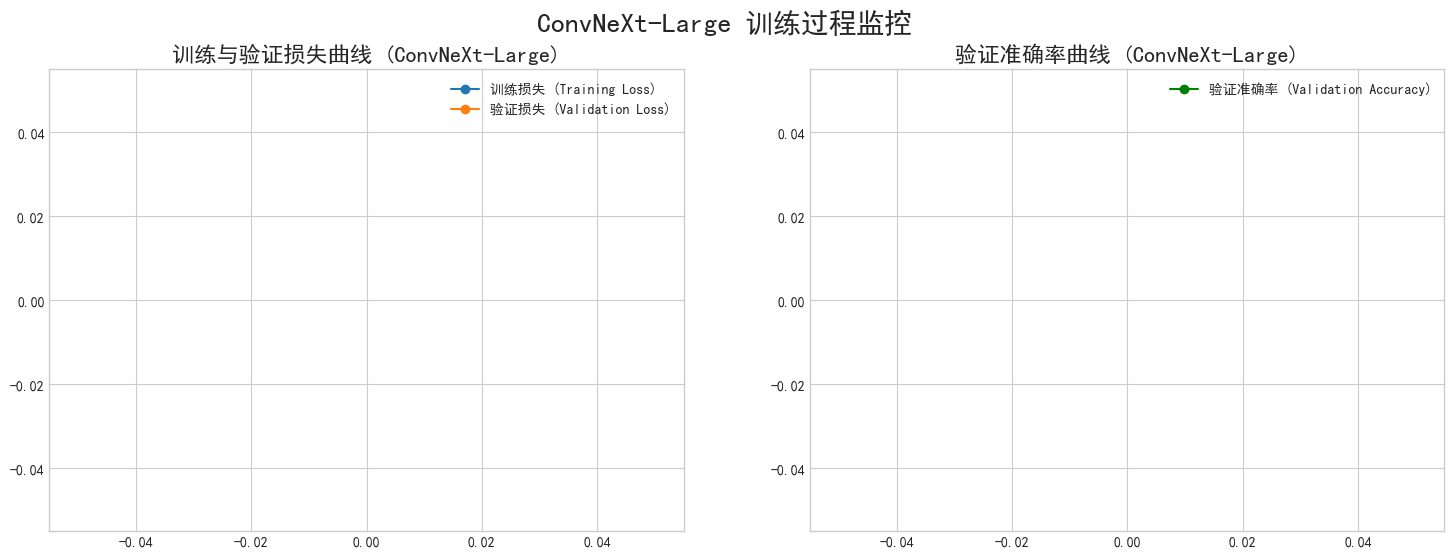

In [ ]:
# --- 3.4 可视化 ---
print("\n--- 开始生成可视化图表 ---")
num_actual_epochs = len(train_loss_history)
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

#解决中文问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

ax1.plot(range(1, num_actual_epochs + 1), train_loss_history, 'o-', label='训练损失 (Training Loss)')
ax1.plot(range(1, num_actual_epochs + 1), val_loss_history, 'o-', label='验证损失 (Validation Loss)')
ax1.set_title('训练与验证损失曲线 (ConvNeXt-Large)', fontsize=16)
ax1.legend()

ax2.plot(range(1, num_actual_epochs + 1), val_acc_history, 'o-', label='验证准确率 (Validation Accuracy)', color='g')
ax2.set_title('验证准确率曲线 (ConvNeXt-Large)', fontsize=16)
ax2.legend()

plt.suptitle('ConvNeXt-Large 训练过程监控', fontsize=20)
plt.show()

---